In [25]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from sklearn import tree
from IPython.display import Image
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [191]:
df = pd.read_csv('datasetpreparato.csv')

In [192]:
df.head()

,Unnamed: 0,Temperature,Humidity,Light,CO2,Occupancy,day,hour,weekend,daylight
0,1,23.18,27.2720,426.0,721.25,1,4,17,0.0,1.0
1,2,23.15,27.2675,429.5,714.00,1,4,17,0.0,1.0
2,3,23.15,27.2450,426.0,713.50,1,4,17,0.0,1.0
3,4,23.15,27.2000,426.0,708.25,1,4,17,0.0,1.0
4,5,23.10,27.2000,426.0,704.50,1,4,17,0.0,1.0


In [193]:
day_moment = []
for i in df.hour:
    if i >= 6 and i <= 12:
        day_moment.append('morning')
    elif i > 12 and i <= 18:
        day_moment.append('afternoon')
    elif i > 18 and i <= 24:
        day_moment.append('evening')
    else:
        day_moment.append('night')
df['day_moment'] = day_moment

In [194]:
df.day_moment.value_counts()

morning      2313
night        2160
afternoon    1869
evening      1800
Name: day_moment, dtype: int64

In [195]:
df.head()

,Unnamed: 0,Temperature,Humidity,Light,CO2,Occupancy,day,hour,weekend,daylight,day_moment
0,1,23.18,27.2720,426.0,721.25,1,4,17,0.0,1.0,afternoon
1,2,23.15,27.2675,429.5,714.00,1,4,17,0.0,1.0,afternoon
2,3,23.15,27.2450,426.0,713.50,1,4,17,0.0,1.0,afternoon
3,4,23.15,27.2000,426.0,708.25,1,4,17,0.0,1.0,afternoon
4,5,23.10,27.2000,426.0,704.50,1,4,17,0.0,1.0,afternoon


In [196]:
df.drop(['Unnamed: 0', 'daylight', 'day', 'hour'], axis = 1, inplace = True)

### one hot encoding alla brutto gesù

In [197]:
cat_morning = []
for i in df.day_moment:
    if i == 'morning':
        cat_morning.append(1)
    else:
        cat_morning.append(0)
df['morning'] = cat_morning
cat_afternoon = []
for j in df.day_moment:
    if j == 'afternoon':
        cat_afternoon.append(1)
    else: 
        cat_afternoon.append(0)
df['afternoon'] = cat_afternoon
cat_evening = []
for k in df.day_moment:
    if k == 'evening':
        cat_evening.append(1)
    else: 
        cat_evening.append(0)
df['evening'] = cat_evening
cat_night = []
for y in df.day_moment:
    if y == 'night':
        cat_night.append(1)
    else:
        cat_night.append(0)
df['night'] = cat_night
    

In [198]:
df.drop(['day_moment'], axis = 1, inplace = True)

### preparazione test

In [199]:
test = pd.read_csv('datatest.txt')

In [200]:
dates = pd.to_datetime(test['date'], infer_datetime_format=True)
test['day'] = dates.dt.day
test['hour'] = dates.dt.hour

In [201]:
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2,14
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2,14
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2,14
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2,14
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2,14


In [202]:
print(test.day.min(), test.day.max())

2 4


In [203]:
weekend = []
for i in test.day:
    if i == 7 or i == 8:
        weekend.append(1)
    else:
        weekend.append(0)
weekend = pd.Series(weekend)
test['weekend'] = weekend

In [204]:
day_moment = []
for i in test.hour:
    if i >= 6 and i <= 12:
        day_moment.append('morning')
    elif i > 12 and i <= 18:
        day_moment.append('afternoon')
    elif i > 18 and i <= 24:
        day_moment.append('evening')
    else:
        day_moment.append('night')
test['day_moment'] = day_moment

In [205]:
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,weekend,day_moment
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2,14,0.0,afternoon
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2,14,0.0,afternoon
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2,14,0.0,afternoon
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2,14,0.0,afternoon
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2,14,0.0,afternoon


In [206]:
cat_morning = []
for i in test.day_moment:
    if i == 'morning':
        cat_morning.append(1)
    else:
        cat_morning.append(0)
test['morning'] = cat_morning
cat_afternoon = []
for j in test.day_moment:
    if j == 'afternoon':
        cat_afternoon.append(1)
    else: 
        cat_afternoon.append(0)
test['afternoon'] = cat_afternoon
cat_evening = []
for k in test.day_moment:
    if k == 'evening':
        cat_evening.append(1)
    else: 
        cat_evening.append(0)
test['evening'] = cat_evening
cat_night = []
for y in test.day_moment:
    if y == 'night':
        cat_night.append(1)
    else:
        cat_night.append(0)
test['night'] = cat_night
    

In [207]:
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,day,hour,weekend,day_moment,morning,afternoon,evening,night
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,2,14,0.0,afternoon,0,1,0,0
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,2,14,0.0,afternoon,0,1,0,0
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,2,14,0.0,afternoon,0,1,0,0
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,2,14,0.0,afternoon,0,1,0,0
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,2,14,0.0,afternoon,0,1,0,0


In [208]:
test = test.reset_index(drop = True)

In [209]:
day_moment = []
for i in test.hour:
    if i >= 6 and i <= 12:
        day_moment.append('morning')
    elif i > 12 and i <= 18:
        day_moment.append('afternoon')
    elif i > 18 and i <= 24:
        day_moment.append('evening')
    else:
        day_moment.append('night')
test['day_moment'] = day_moment

In [210]:
test.drop(['date', 'day', 'hour', 'day_moment', 'HumidityRatio'], axis = 1, inplace = True)

In [211]:
df.head()

,Temperature,Humidity,Light,CO2,Occupancy,weekend,morning,afternoon,evening,night
0,23.18,27.2720,426.0,721.25,1,0.0,0,1,0,0
1,23.15,27.2675,429.5,714.00,1,0.0,0,1,0,0
2,23.15,27.2450,426.0,713.50,1,0.0,0,1,0,0
3,23.15,27.2000,426.0,708.25,1,0.0,0,1,0,0
4,23.10,27.2000,426.0,704.50,1,0.0,0,1,0,0


In [212]:
test.head()

,Temperature,Humidity,Light,CO2,Occupancy,weekend,morning,afternoon,evening,night
0,23.7000,26.272,585.200000,749.200000,1,0.0,0,1,0,0
1,23.7180,26.290,578.400000,760.400000,1,0.0,0,1,0,0
2,23.7300,26.230,572.666667,769.666667,1,0.0,0,1,0,0
3,23.7225,26.125,493.750000,774.750000,1,0.0,0,1,0,0
4,23.7540,26.200,488.600000,779.000000,1,0.0,0,1,0,0


In [213]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(df.drop(['Occupancy'], axis=1),df.Occupancy)

In [214]:
pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

In [215]:
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('decisiontree', decisiontree)])
n_components = list(range(1,X_train.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10]

In [216]:
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [217]:
clf = GridSearchCV(pipe, parameters)

In [218]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                             

In [219]:
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
# print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=4, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: gini
Best max_depth: 6

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.97786093 0.94979732 0.98004365 0.95260368]

0.965076395385095

0.01393271319784775


In [231]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf = clf.fit(X_train, y_train)

In [232]:
X_test = test.drop(['Occupancy'], axis=1)

# X_TEST HA MISSING VALUES NON SO PERCHE'

In [233]:
X_test.dropna( axis = 0, inplace = True)

In [235]:
X_test.shape

(2525, 9)

In [234]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [236]:
y_pred.shape

(2525,)

#### FEATURE IMPORTANCE

In [237]:
for col, imp in zip(X_test.columns, clf.feature_importances_):
    print(col, imp)
    
cols = [(col) for col, imp in zip(X_test.columns, clf.feature_importances_) if imp == 0]
print(cols)

Temperature 0.013734015602713244
Humidity 0.002215553379989438
Light 0.9570118097571682
CO2 0.01809627035972453
weekend 0.008301990870862922
morning 0.0006403600295417915
afternoon 0.0
evening 0.0
night 0.0
['afternoon', 'evening', 'night']


In [225]:
## A QUANTO PARE LA LUCE E' L'UNICO PARAMETRO IMPORTANTE, MAGARI SERVE DEL FEATURE ENGINEERING 

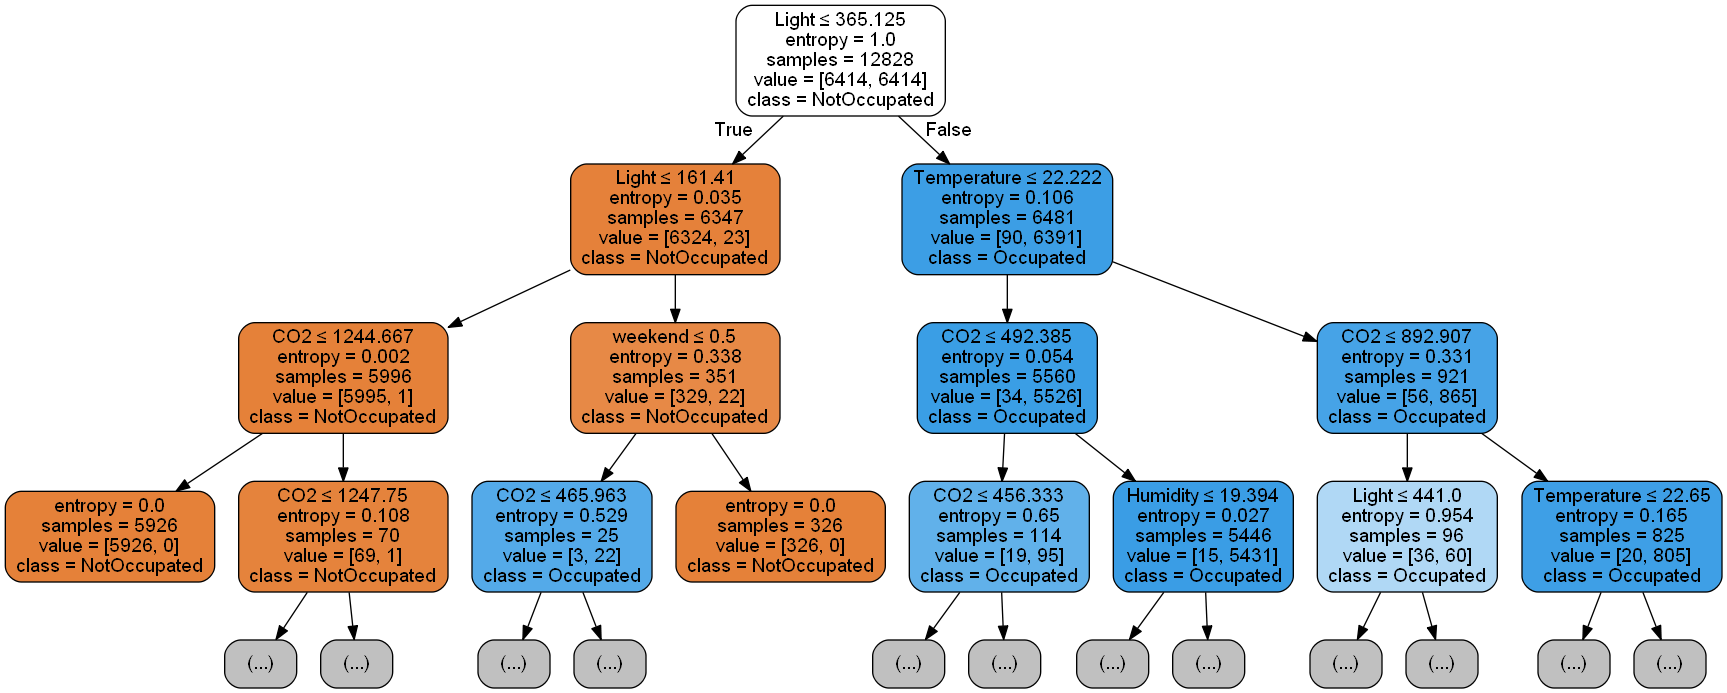

In [238]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns,
                                class_names=['Occupated' if x == 1 else 'NotOccupated' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [241]:
for i in y_test:
    print(i)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [240]:
y_pred.shape

(2525,)

In [242]:
y_test = test.Occupancy[:2525]

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='binary', pos_label=0))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s\n' % f1_score(y_test, y_pred, pos_label=0))

print('Classification report train:')
print(classification_report(y_train, y_pred_tr))

print('Classification report test:')
print(classification_report(y_test, y_pred))

print('precision recall f1 support:')
print(precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=0))
print()

print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.9981290926099158
Train F1-score 0.9981279251170047

Test Accuracy 0.9378217821782178
Test F1-score 0.9538642374375551

Classification report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6414
           1       1.00      1.00      1.00      6414

    accuracy                           1.00     12828
   macro avg       1.00      1.00      1.00     12828
weighted avg       1.00      1.00      1.00     12828

Classification report test:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1682
           1       0.93      0.88      0.90       843

    accuracy                           0.94      2525
   macro avg       0.93      0.92      0.93      2525
weighted avg       0.94      0.94      0.94      2525

precision recall f1 support:
(0.9430563625798954, 0.964922711058264, 0.9538642374375551, None)

Confusion matrix:
[[6398   16]
 [   8 6406]]


## CROSS VALIDATION

In [243]:
from sklearn.model_selection import cross_val_score

In [244]:
scores = cross_val_score(clf, X_train, y_train, cv=100)
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.90697674,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.8372093 , 0.68992248, 0.98449612,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99224806, 1.        , 1.        , 1.        ,
       1.        , 0.90697674, 0.94573643, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.96875   , 0.984375  , 0.796875  , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9921875 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9921875 ,
       1.        , 0.9921875 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [245]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
scores

array([0.97270624, 0.99259529, 0.94175711, 0.97542424, 0.92557151])

In [246]:
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1_macro')
scores

array([0.98986661, 0.94843373, 0.98362957, 1.        , 0.88965909,
       0.99844115, 0.97504571, 1.        , 0.97502709, 0.99765989])

## TUNING DEI PARAMETRI

#### profondità con f1 score e AUC

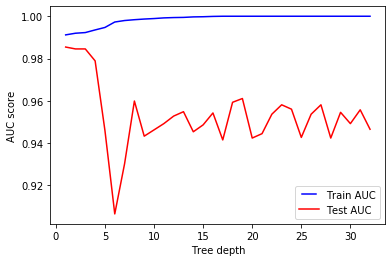

In [247]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

In [248]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

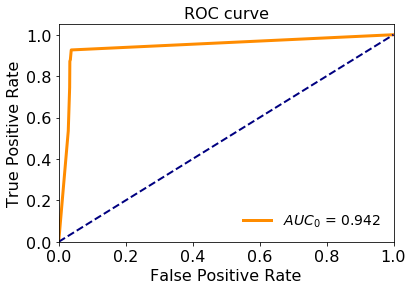

In [249]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()